# Семинар 3. Метод K-ближайших соседей

Добро пожаловать на первый семинар по машинному обучению в рамках нашего курса. Сначала разберем базовые концепции, а затем перейдем к основной теме — методу K-ближайших соседей.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

Напомним, что машинное обучение (_machine learning_, ML) можно разделить на обучение с учителем (_supervised learning_) и обучение без учителя (_unsupervised learning_). К обучению без учителя относятся, например, методы кластеризации и снижения размерности. О них мы подробнее поговорим на более поздних семинарах.

Обычно мы имеем дело с $ n $ объектами, каждый из которых описывается набором из $ d $ признаков. Запишем их в виде матрицы:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1d} \\
x_{21} & x_{22} & \dots & x_{2d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nd} \\
\end{bmatrix},
$$

где $ x_{ij} $ — значение $ j $-го признака для $ i $-го объекта.

В случае обучения с учителем нам также даны правильные ответы для этих объектов:

$$
y = 
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}.
$$

Сегодня мы рассмотрим две постановки задачи, относящиеся к обучению с учителем: классификацию и регрессию.


## Классификация

В общем случае для задачи классификации $ y_i \in \{0,1,\dots,K-1\} $, где $ K $ — число классов. В качестве примера мы будем рассматривать бинарную классификацию, то есть $ y_i \in \{0,1\} $.

Итак, перед началом работы создадим себе проблему...

In [2]:
X, y = make_classification(
    n_samples=1_000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=0.5,
    random_state=42,
)

Чтобы иметь возможность оценить качество модели, необходимо разделить данные на обучающую и тестовые подвыборки.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print("Train size:", y_train.size)
print("Test size:", y_test.size)

Train size: 750
Test size: 250


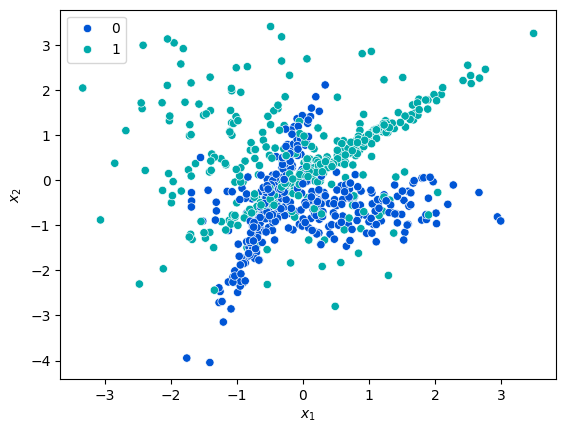

In [4]:
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="winter")
plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")
plt.show()

## Метод K-ближайших соседей

Метод K-ближайших соседей основан на простой и интуитивно понятной идее: если объекты $\mathbf{x}_i$ и $\mathbf{x}_j$ близки в пространстве признаков, то их метки $y_i$ и $y_j$ скорее всего совпадают. Но как измерить близость двух векторов?

Один из самых простых и распространенных способов — использовать Евклидово расстояние.

$$
d(\mathbf{x}_i, \mathbf{x}_j) = \sqrt{\sum_{k=1}^{d}\bigl(\mathbf{x}_{ik} - \mathbf{x}_{jk}\bigr)^2}
$$


Теперь на основе этой идеи давайте построим наш первый алгоритм машинного обучения. На этапе **обучения** мы будем просто **запоминать наши обучающие данные** (объекты и их целевые переменные). Далее для нового объекта мы будем считать расстояния от него до всех объектов обучающей выборке и брать топ-$ K $ наиболее близких. На основе их меток будем голосованием решать, к какому классу отнести наш новый объект.

Итак, сделаем предсказание для одного объекта.

In [5]:
x = X_test[1].reshape(-1, 2)
x

array([[ 1.0692748 , -0.66103561]])

In [6]:
# Посчитаем Евклидово расстояние
distances = ((X_train - x) ** 2).sum(axis=1) ** 0.5

# Найдем K ближайших к нашей точке объектов (соседей)
K = 5
neighbors = y_train[np.argsort(distances)][:K]
print("Neighbors: ", neighbors)

# Проведем голосование среди соседей 
labels, counts = np.unique(neighbors, return_counts=True)

print("Labels:", labels)
print("Counts:", counts)
print("Probabilities:", counts / counts.sum())

print("Predicted label:", labels[np.argmax(counts)])

Neighbors:  [0 0 0 1 1]
Labels: [0 1]
Counts: [3 2]
Probabilities: [0.6 0.4]
Predicted label: 0


Сравним результат с имплементацией `sklearn.neighbors.KNeighborsClassifier`. Все модели в библиотеке scikit-learn имеют стандартизированный интерфейс:
- метод `fit(X, y)` используется для обучения и возвращает обученную модель;
- метод `predict(X)` предсказывает метки для объектов;
- метод `predict_proba(X)`, если имплементирован, возвращает вероятности классов.

In [7]:
# Создадим необученный классификатор
classifier = KNeighborsClassifier()

# Обучим его на наших данных
classifier.fit(X_train, y_train)

# Для удобства код выше можно записать в одну строку
classifier = KNeighborsClassifier().fit(X_train, y_train)

In [8]:
print("Probabilities:", *classifier.predict_proba(x))
print("Predicted label:", *classifier.predict(x))

Probabilities: [0.6 0.4]
Predicted label: 0


Теперь сделаем предсказания для всех тестовых объектов

In [9]:
# Сделаем предсказания для всех тестовых объектов
y_pred = classifier.predict(X_test)

Наконец, мы можем оценить качество модели. Для простоты будем использовать _accuracy_ — долю верных ответов.

$$
\mathrm{Accuracy} \;=\; \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}\bigl[\hat{y}_i = y_i\bigr]
$$

In [10]:
# Оценим обученный классификатор
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:", round(accuracy, 3))

Accuracy: 0.816


У большинства моделей машинного обучения есть параметры, которые обучаются, и гиперпараметры, которые мы определяем до начала обучения. Важнейший гиперпараметр KNN — количество соседей $K$. Подобрать подходящее значение гиперпараметра можно при помощи валидационной выборки или кросс-валидации.

<span style="color:red">Но ни в коем случае не подбирайте его на тестовых данных!</span>

In [11]:
classifier = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": range(1, 100, 5)})
classifier.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': range(1, 100, 5)}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,11


In [12]:
classifier.best_params_

{'n_neighbors': 11}

In [13]:
# Сделаем предсказания для модели с K=11
y_pred = classifier.predict(X_test)

# Оценим новую модель
print(f"Accuracy:\t{accuracy_score(y_test, y_pred):.3f}")

Accuracy:	0.828


А как зависит метрика качества от значения $ K $? Предположите, почему зависимость имеет такой вид.

Text(0, 0.5, 'Accuracy')

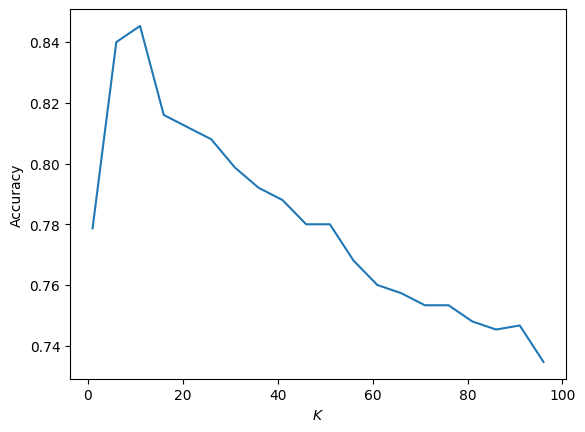

In [14]:
cv_results = pd.DataFrame(classifier.cv_results_)
sns.lineplot(data=cv_results, x="param_n_neighbors", y="mean_test_score")
plt.xlabel("$ K $")
plt.ylabel("Accuracy")

Теперь рассмотри такую ситуацию: пусть ближайшие соседи некоторой точки имеют вид

| класс | расстояние |
| ----- | ---------- |
| 0     | 1          |
| 0     | 1          |
| 1     | 2          |
| 1     | 2          |
| 1     | 3          |

При $ K = 5 $ мы скажем, что она относится к классу `1`. Но ведь точки с меткой `0` ближе! Хочется как-то учесть расстояния в предсказаниях. Но как это сделать?

До этого каждая точка вносила одинаковый вклад в результаты голосования. Сейчас же нам нужно, чтобы далекие точки были менее важны. Давайте каждой точке присвоим вес, который будет обратно пропорционален расстоянию. Чем больше расстояние до точки, тем меньше ее вес. Тогда в нашем примере получим следующие результаты голосования:

Класс `0`: $ \tfrac{1}{1} + \tfrac{1}{1} = 2 $  
Класс `1`: $ \tfrac{1}{2} + \tfrac{1}{2} + \tfrac{1}{3} \approx 1.3 $

И класс `0` победил! Проверим, как это работает на практике.


In [15]:
classifier = KNeighborsClassifier(n_neighbors=11, weights="distance").fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Accuracy:\t{accuracy_score(y_test, y_pred):.3f}")

Accuracy:	0.836


Стало ли лучше?

Наконец, посмотрим на то, как наша модель разделяет пространство признаков.

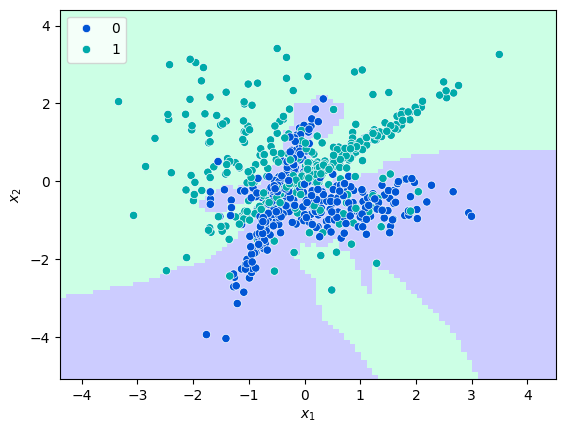

In [16]:
x1_min, x2_min = X_train.min(axis=0) - 1
x1_max, x2_max = X_train.max(axis=0) + 1

x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1), np.arange(x2_min, x2_max, 0.1))

classifier = KNeighborsClassifier(n_neighbors=11).fit(X_train, y_train)
y = classifier.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

plt.pcolormesh(x1, x2, y, cmap="winter", alpha=0.2)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="winter")

plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")

plt.show()

## Масштабирование признаков

На практике признаки могут иметь очень разные масштабы. Смоделируем подобную ситуацию и посмотрим, что произойдет с метрикой.

In [17]:
for X in (X_train, X_test):
    X[:, 1] *= 10.0

In [18]:
classifier = KNeighborsClassifier().fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Accuracy:\t{accuracy_score(y_test, y_pred):.3f}")

Accuracy:	0.788


О, ужас! Как вы думаете, что случилось?

**Подсказка:** для ответа на этот вопрос вспомните, как мы считаем расстояние между объектами.

Самый простой способ исправить ситуацию — привести все признаки к одному масштабу. Например, мы можем вычесть среднее значение признака и разделить результат на его стандартное отклонение. В scikit-learn для этого служит `sklearn.preprocessing.StandardScaler`.

In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
classifier = KNeighborsClassifier().fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
print(f"Accuracy:\t{accuracy_score(y_test, y_pred):.3f}")

Accuracy:	0.820


## Регрессия

В задаче регрессии наши $y_i \in \mathbb{R}$. Снова создадим себе проблему, разобьем данные на обучающую и тестовую выборки и посмотрим на совместное распределение признаков.

In [21]:
X, y = make_regression(
    n_samples=1_000,
    n_features=2,
    n_informative=2,
    noise=1.0,
    random_state=42,
)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("Train size:", y_train.size, sep="\t")
print("Test size:", y_test.size, sep="\t")

Train size:	750
Test size:	250


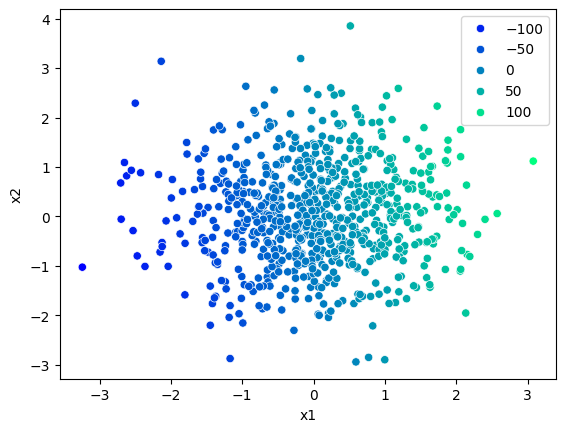

In [23]:
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="winter")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

Как же сделать предсказания в таком случае? Можем просто усреднить значения целевой переменной соседей. Если же мы хотим учесть расстояния, то можно заменить арифметическое среднее на взвешенное среднее

Для оценки качества модели регрессии используем среднюю абсолютную ошибку (Mean Absolute Error, MAE):

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n \lvert y_i - \hat{y}_i \rvert,
$$

где $ y_i $ — истинные значения, $ \hat{y}_i $ — предсказания модели, $ n $ — число объектов.


In [24]:
regressor = KNeighborsRegressor().fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f"MAE:\t{mean_absolute_error(y_test, y_pred):.3f}")

MAE:	2.115
